##### Modeling: Predict total_sales

- To load the data from end of EDA process, and to compare the results by traditional machining (RandomForest) and MLP

- Save the model

In [1]:
# load the data 
import pandas as pd
df = pd.read_csv('df_with_sentiment.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6208 entries, 0 to 6207
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             6208 non-null   int64  
 1   title                  6208 non-null   object 
 2   platform               6208 non-null   object 
 3   releaseDate            6208 non-null   object 
 4   rating                 6208 non-null   object 
 5   genres                 6208 non-null   object 
 6   quote                  6208 non-null   object 
 7   score                  6208 non-null   float64
 8   total_sales            6208 non-null   float64
 9   original_price         6208 non-null   float64
 10  release_year           6208 non-null   int64  
 11  release_quarter        6208 non-null   int64  
 12  release_month          6208 non-null   int64  
 13  processed_tokens       6208 non-null   object 
 14  clean_text_stemmed     6184 non-null   object 
 15  clea

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

# Choose X, y coulmns
X = df.drop(['Unnamed: 0','title', 'quote', 'releaseDate', 'total_sales', 'processed_tokens',
              'clean_text_stemmed', 'clean_text_lemmatized', 'entities', 'frequency', 
              'sentiment' ], axis=1, errors='ignore')
X = pd.get_dummies(X, columns=['platform', 'rating', 'genres', 'predicted_sentiment'], drop_first=True)

y = df['total_sales']


print(X.shape)
# Impute Missing value for X??
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Spilt data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

# Modeling : RandomForest
model = RandomForestRegressor(random_state=42)

# RMSE definition : --> cross_ val_score does not have RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Cross_validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=rmse_scorer)

# fit the model
model.fit(X_train, y_train)

# Prediction and Evaluation
y_pred = model.predict(X_test)
print(f"Model1: RamodemForest")

print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R² score:", r2_score(y_test, y_pred))



(6208, 50)
Model1: RamodemForest
RMSE: 0.0008197901096865468
R² score: 0.9999944051641748


In [17]:
# Test: Save the model


import joblib
# Save model, imputer, and model features
joblib.dump(model, 'Model/rf_model.pkl')
joblib.dump(imputer, 'Model/imputer.pkl')
joblib.dump(X.columns.to_list(), 'Model/model_features.pkl')
print('Finish :save models!')

# Keras
#model.save('model.h5')
#model = keras.models.load_model('model.h5')

Finish :save models!


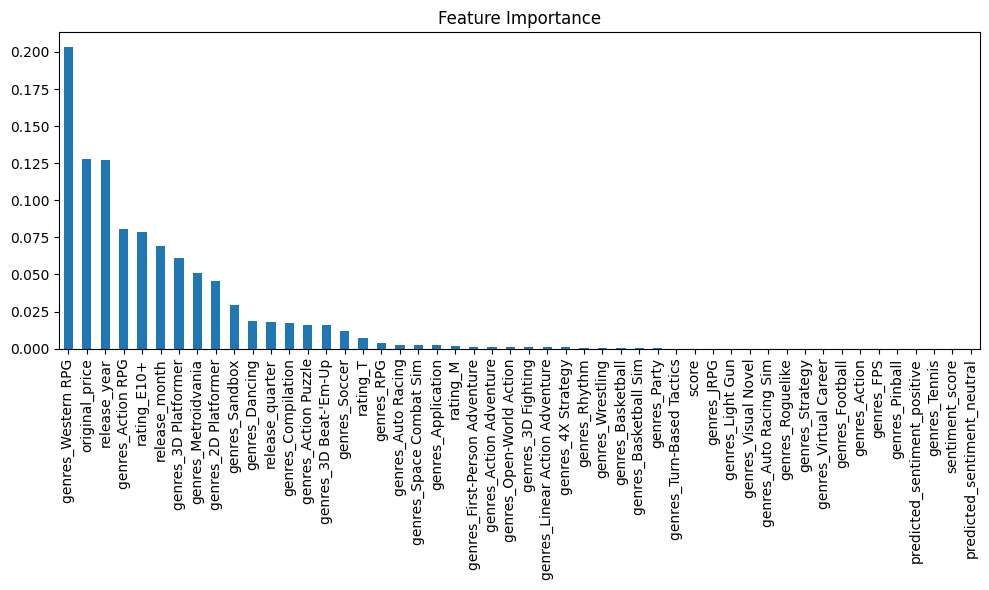

In [5]:
# Feature Importance 

importances = model.feature_importances_
feature_names = X_test.columns


import pandas as pd
import matplotlib.pyplot as plt

# top8 feature
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(10, 6), title='Feature Importance')
plt.tight_layout()
plt.show()


In [9]:
# model2 : MLP

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Standardize
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


# grid search by using different hyper-paramenter
from itertools import product

# Hyper Paramenter setting
architectures = [(64,), (100, 50)]
learning_rates = [0.001, 0.01]
alphas = [0.0001, 0.001]
activations = ['relu', 'tanh']

# 用 itertools.product grid 
param_grid = [
    {'arch': arch, 'lr': lr, 'alpha': alpha, 'act': act}
    for arch, lr, alpha, act in product(architectures, learning_rates, alphas, activations)
]



results = []


for params in param_grid:
    # Create Models
    model = MLPRegressor(
            hidden_layer_sizes=params['arch'],
            activation=params['act'],
            solver='adam',
            learning_rate_init=params['lr'],
            alpha=params['alpha'],
            max_iter=1000,
            early_stopping=True,
            random_state=42
        )

   # CV RMSE
    cv_rmse = cross_val_score(model, X_train, y_train, cv=5,
                              scoring=make_scorer(mean_squared_error, squared=False)).mean()

    #training and testing
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_rmse = mean_squared_error(y_test, y_pred, squared=False)
    test_r2 = r2_score(y_test, y_pred)

    # Print Result
    results.append({
        'Architecture': str(params['arch']),
        'Learning Rate': params['lr'],
        'Alpha': params['alpha'],
        'Activation': params['act'],
        'CV RMSE': round(cv_rmse, 4),
        'Test RMSE': round(test_rmse, 4),
        'Test R²': round(test_r2, 4)
    })

# Print it as a table 
results_df = pd.DataFrame(results).sort_values(by='Test RMSE')
display(results_df)

,Architecture,Learning Rate,Alpha,Activation,CV RMSE,Test RMSE,Test R²
5,"(64,)",0.010,0.0001,tanh,0.0272,0.0100,0.9992
13,"(100, 50)",0.010,0.0001,tanh,0.0126,0.0123,0.9987
15,"(100, 50)",0.010,0.0010,tanh,0.0114,0.0127,0.9987
12,"(100, 50)",0.010,0.0001,relu,0.0229,0.0137,0.9984
7,"(64,)",0.010,0.0010,tanh,0.0287,0.0148,0.9982
9,"(100, 50)",0.001,0.0001,tanh,0.0203,0.0150,0.9981
11,"(100, 50)",0.001,0.0010,tanh,0.0195,0.0151,0.9981
14,"(100, 50)",0.010,0.0010,relu,0.0207,0.0179,0.9973
1,"(64,)",0.001,0.0001,tanh,0.0345,0.0187,0.9971
3,"(64,)",0.001,0.0010,tanh,0.0349,0.0191,0.9969
